# Predicting AFL winners using Machine Learning - Predictions

---

<img src='img/coinflip.jpg'>

---

Great! We have a good thing going. With the accuracy that we have we'd make bank in no time. Or will we? According to a study set by Victor Haghani & Richard Dewey in 2016 suggested otherwise. In their study 61 people young men and women were given \$25 and 30 minutes to bet on a coin 300 times, of which they were allowed to keep their winnings up to a cap of $250.

The catch? The coin was biased. They were advised ahead of time that the coin would flip heads 60% of the time, and that their bets were double or nothing. Now with a simple percentage betting strategy. 95% of the time you should be able to reach the maximum payout.

Here is a link to the study: [Rational Decision-Making Under Uncertainty: Observed Betting Patterns on a Biased Coin](https://poseidon01.ssrn.com/delivery.php?ID=458117106069071089112102093104086118051053051021058043068127070104100112011076090102036054032126054012052113019031090109078011038007053017081066016119005031087091101047050010104102015004105093021076114091122126095070021096124120114123120087067121003027&EXT=pdf)

**The Results**

     - 3 in 10 people went bust.
     
     - The Average Payout of those that did reach the maximum and didnt go bust was $75. Representing 51%
     
     - 67% of people at one point bet Tails

<img src='img/3in10.png'>


     
I guess what I'm trying to say here is that, I wouldnt trust myself to bet either. So might as well get the computer to do that part as well. Which leads up to Section 3 - Tipping.

### Kelly Criterion

---

The basic premise behind this section is to compare our predicted probabilities of each team winning with the bookies open odds. From there we can bet an appropriate proportion of our bank maximize our long term gain.

### $$f^{\prime} = \frac{bp-q}{b} = \frac{p(b+1)-1}{b}$$

    - f* is the fraction of the current bankroll to wager, i.e. how much to bet
    - b is the net odds received on the wager ("b to 1")
    - p is the probability of winning;
    - q is the probability of losing, which is 1 − p.

In [1212]:
# Imports dependencies
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(font_scale=2)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

%matplotlib inline

In [1213]:
full_matches = pd.read_csv("data/afl_2018_test.csv", index_col = 0)

In [1214]:
full_matches.head(3)

,Date,h_team,a_team,Home Score,Away Score,play_off,home_odds,away_odds,season,margin,h_prevladder_score,a_prevladder_score,margins_prev_match1,margins_prev_match2,margins_prev_match3,margins_prev_match4,margins_prev_match5,win_loc
0,2018-03-25,West Coast,Sydney,0,0,0,2.60,1.50,2018,0,48.0,56.0,26.0,-39.0,52.0,-28.0,-34.0,0
1,2018-03-25,Melbourne,Geelong,0,0,0,2.35,1.60,2018,0,48.0,62.0,-29.0,-111.0,24.0,-66.0,-68.0,0
2,2018-03-25,GWS Giants,Western Bulldogs,0,0,0,1.45,2.75,2018,0,60.0,44.0,48.0,2.0,-6.0,25.0,-45.0,0


### Bringing back the Helper Code

In [1215]:
from time import time 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = cross_val_predict(clf, features, target, cv=5)
    
    score = cross_val_score(clf, features, target, cv = 5).mean()
    
    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred), score


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    print("-----------------------------------------------------------------------")

<a id='change_year'></a>

### Lets set the year!

---

One of the more important sections in this notebook would be the year - So lets set it here!!! Because it will take the 4 previous years to train on.

<a href='#go_back'>Go Back!</a>

In [1216]:
# Sets the year of the model: year
year = 2016

### And the model itself!

---

There wouldn't be much to do if we didn't have the model itself.

In [1217]:
import patsy

features = '~ season + h_prevladder_score + a_prevladder_score + play_off + margins_prev_match1 + margins_prev_match2 + \
            + margins_prev_match3 + margins_prev_match4 + margins_prev_match5 + home_odds + away_odds + C(h_team) + C(a_team) - 1'

In [1218]:
# Initiates the predictors: X
X = patsy.dmatrix(features, data=full_matches, return_type='dataframe')

# Initiates the target as winloc: y
y = full_matches[["season", "win_loc"]]

In [1219]:
X.shape

(959, 46)

In [1220]:
y.shape

(959, 2)

In [1221]:
def five_year_pred(clf, X, y, year):
    
    global baseline
    baseline = full_matches[full_matches["season"] == year]["win_loc"].mean()
    
    
    print("The baseline score for year {} is {:.2f}%\n".format(year, baseline))
    print("-----------------------------------------------------------------------")
    
    global X_train
    X_train = X[(X["season"] >= year-5) & (X["season"] <= year-1)].drop(["season"], axis=1)
    global X_test
    X_test  = X[X["season"] == year].drop(["season"], axis=1)
    global y_train
    y_train = y[(y["season"] >= year-5) & (y["season"] <= year-1)]["win_loc"]
    global y_test
    y_test  = y[y["season"] == year]["win_loc"]
  
    train_predict(clf, X_train, y_train, X_test, y_test)

    predictions =  clf.predict_proba(X_test)
    
    year_data = full_matches[full_matches["season"] == year]

    cols_to_keep = ["win_loc", "season", "h_team", "a_team", "home_odds", "away_odds"]
    year_data = year_data[cols_to_keep].reset_index(drop=True)
    
    probs_df = pd.DataFrame(predictions, columns = ["a_prob_us", "h_prob_us"]).round(2)
    probs_df = probs_df[["h_prob_us", "a_prob_us"]]
    
    year_odds_comparison = year_data.join(probs_df, how="outer")

    return year_odds_comparison

In [1222]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

clf_lr      = LogisticRegression(penalty='l2', solver="liblinear")
clf_svc     = SVC(kernel = 'rbf', probability = True)
clf_xgboost = GradientBoostingClassifier()
clf_forest   = RandomForestClassifier()
clf_tree    = DecisionTreeClassifier()

clf = clf_lr

probs_df = five_year_pred(clf, X, y, year = year)

The baseline score for year 2016 is 0.60%

-----------------------------------------------------------------------
Training a LogisticRegression using a training set size of 542. . .
Trained model in 0.0030 seconds
Made predictions in 0.0311 seconds.
F1 score and accuracy score for training set: 0.7231 , 0.6862.
Made predictions in 0.0170 seconds.
F1 score and accuracy score for test set: 0.7459 , 0.6920.
-----------------------------------------------------------------------


### GridSearch - Helper code.

--- 

For the purpose of this notebook I have opted not to apply a gridsearch. But the code is as below.

### $$f^{\prime} = \frac{bp-q}{b} = \frac{p(b+1)-1}{b}$$

    - f' is the fraction of the current bankroll to wager, i.e. how much to bet
    - b is the net odds received on the wager ("b to 1")
    - p is the probability of winning;
    - q is the probability of losing, which is 1 − p.

In [1223]:
betting_outcomes = probs_df[["h_team", "a_team", "win_loc", "home_odds", "away_odds", "h_prob_us", "a_prob_us"]]
betting_outcomes.head(3)

,h_team,a_team,win_loc,home_odds,away_odds,h_prob_us,a_prob_us
0,Sydney,Western Bulldogs,0,1.51,2.60,0.75,0.25
1,GWS Giants,Western Bulldogs,0,1.38,3.04,0.75,0.25
2,Geelong,Sydney,0,1.66,2.23,0.75,0.25


In [1224]:
def team_to_bet(home_odds, away_odds, h_prob_us, a_prob_us, bet_type="home"):
    """
    Advises on which team to bet on.
    
    By comparing the odds of a model and public odds, returns which team should be bet on.

    Parameters
    ----------
    
    Returns
    -------
    int: The return value.
    0 for away team.
    1 for home team. 
    """
    
    # This bet type plays the odds, in an ideal case where we have an accurate model, playing the odds will have a greater
    # net gain compared to all other models.
    if bet_type == "odds":
        # Calculates bookie probabilities based on their odds: home_prob_bookie, away_prob_bookie
        h_prob_bookie = 1/home_odds
        a_prob_bookie = 1/away_odds

        # Calculates differences in probabilities: home_prob_diff, away_prob_diff
        home_prob_diff = h_prob_us - h_prob_bookie
        away_prob_diff = a_prob_us - a_prob_bookie

        # Returns 1 if we are more sure that the home team will win.
        if (home_prob_diff > away_prob_diff):
            return 1

        # Returns -1 if we are more sure that the away team will win.
        if (away_prob_diff > home_prob_diff):
            return 0    
    
    # This bet type only predominantly bets on the home teams
    if bet_type == "home":
        
        # Returns 1 if home team are favored
        if (h_prob_us > a_prob_us):
            return 1
        
        # Returns 0 if away team are favored
        else:
            return 0

    
        
def kelly_criterion(prob, odds):
    """
    Applies the kelly criterion to advise what percentage of bank to bet.
    
    Uses the probability of team winning with the expected odds to 
    
    Returns
    -------
    float: The return value. 2 d.p.
    The percentage of ones bank to bet on a game.
    """
    
    # Calculates the percentage to bet based on probability and odds
    bet_perc = (prob * (odds + 1)-1) / odds
    
    # Returns bet_perc
    return abs(round(bet_perc,2))

def calc_win(bet, odds):
    """
    Calculates the amount won from a winning bet given odds and the bet_size
    """
    return (bet) * (odds-1)


### Which team to bet on & how much?

---

Lets create 2 additional columns, one which advises us who to bet on and the other which tells us how much to bet

In [1225]:
# Creates a column that advises which team to bet on
betting_outcomes["bet_on"] = betting_outcomes.apply(lambda row: team_to_bet(row["home_odds"], row["away_odds"],
                                                                            row["h_prob_us"], row["a_prob_us"],
                                                                            bet_type = "home"), axis = 1)
# Creates a column that advises how much to bet
betting_outcomes["bet_perc"] = betting_outcomes.apply(lambda row: kelly_criterion(row["h_prob_us"], row["home_odds"]), axis = 1)/3


In [1226]:
# Initiates the columns for later use
betting_outcomes["bet_size"]  = 100.00
betting_outcomes["bank"]      = 100.00
betting_outcomes["new_bank"]  = 100.00
betting_outcomes["bet_size"]  = 0.00
betting_outcomes["earn_loss"] = 0.00

<a id='change_bettype'></a>

### Should we always bet on the home team recommendations? Away team recommendations? Or both?

---

<a href='#go_back'>Go Back!</a>

In [1227]:
betting_outcomes_home = betting_outcomes[betting_outcomes["bet_on"] == 1]
betting_outcomes_home.index.names = ['match_num']
betting_outcomes_home.reset_index(inplace=True)
betting_outcomes_home.head(3)

,match_num,h_team,a_team,win_loc,home_odds,away_odds,h_prob_us,a_prob_us,bet_on,bet_perc,bet_size,bank,new_bank,earn_loss
0,0,Sydney,Western Bulldogs,0,1.51,2.60,0.75,0.25,1,0.193333,0.0,100.0,100.0,0.0
1,1,GWS Giants,Western Bulldogs,0,1.38,3.04,0.75,0.25,1,0.190000,0.0,100.0,100.0,0.0
2,2,Geelong,Sydney,0,1.66,2.23,0.75,0.25,1,0.200000,0.0,100.0,100.0,0.0


In [1228]:
for index, row in betting_outcomes_home.iterrows():
    
    bet_size = betting_outcomes_home.iloc[index, -3] * betting_outcomes_home.iloc[index, -5]
    betting_outcomes_home.set_value(index, "bet_size", round(bet_size,2))
    
    if row["bet_on"] == 1:
        if row["bank"] <= 10:
            print("Index is {}".format(index))

            bank = betting_outcomes.iloc[index, -3]    

            betting_outcomes.set_value(index, "earn_loss", 0)
            betting_outcomes.set_value(index, "new_bank", bank)
            betting_outcomes.set_value(index+1, "bank", bank)
            betting_outcomes.set_value(index, "bet_size", 0.00)   

        else:
            if row["win_loc"] == 1:
                earn = calc_win(betting_outcomes_home.iloc[index, -4], betting_outcomes_home.iloc[index, 4])
                new_bank = betting_outcomes_home.iloc[index, -3] + earn 
                bank = betting_outcomes_home.iloc[index, -3]

                betting_outcomes_home.set_value(index, "earn_loss", earn)
                betting_outcomes_home.set_value(index, "new_bank", new_bank)
                betting_outcomes_home.set_value(index+1, "bank", new_bank)  

            elif row["win_loc"] == 0:
                loss = betting_outcomes_home.iloc[index, -4]
                new_bank = betting_outcomes_home.iloc[index, -3] - loss
                bank = betting_outcomes_home.iloc[index, -3]

                betting_outcomes_home.set_value(index, "earn_loss", -loss)
                betting_outcomes_home.set_value(index, "new_bank", new_bank)
                betting_outcomes_home.set_value(index+1, "bank", new_bank)   
                
    if row["bet_on"] == 0:
        if row["bank"] <= 10:
            print("Index is {}".format(index))

            bank = betting_outcomes.iloc[index, -3]    

            betting_outcomes.set_value(index, "earn_loss", 0)
            betting_outcomes.set_value(index, "new_bank", bank)
            betting_outcomes.set_value(index+1, "bank", bank)
            betting_outcomes.set_value(index, "bet_size", 0.00)  
        
        else:
            if row["win_loc"] == 1:
                loss = betting_outcomes_home.iloc[index, -4]
                new_bank = betting_outcomes_home.iloc[index, -3] - loss
                bank = betting_outcomes_home.iloc[index, -3]

                betting_outcomes_home.set_value(index, "earn_loss", -loss)
                betting_outcomes_home.set_value(index, "new_bank", new_bank)
                betting_outcomes_home.set_value(index+1, "bank", new_bank)

            elif row["win_loc"] == 0:
                earn = calc_win(betting_outcomes_home.iloc[index, -4], betting_outcomes_home.iloc[index, 5])
                new_bank = betting_outcomes_home.iloc[index, -3] + earn 
                bank = betting_outcomes_home.iloc[index, -3]

                betting_outcomes_home.set_value(index, "earn_loss", earn)
                betting_outcomes_home.set_value(index, "new_bank", new_bank)
                betting_outcomes_home.set_value(index+1, "bank", new_bank)  
                
betting_outcomes_home = betting_outcomes_home.round({'bet_size': 2,
                           'bet_perc': 2,
                           'bank': 2,
                           'new_bank':2,
                           'earn_loss':2})

In [1229]:
betting_outcomes_home.fillna(0, inplace=True)

In [1230]:
cols_to_change = ['match_num', 'win_loc', 'bet_on']

for col in cols_to_change:
    betting_outcomes_home[col] = betting_outcomes_home[col].astype(int)

### Results

---

First of all lets have a look at the starting and trailing few bets.

In [1231]:
# First 10 bets
betting_outcomes_home.head(24)

,match_num,h_team,a_team,win_loc,home_odds,away_odds,h_prob_us,a_prob_us,bet_on,bet_perc,bet_size,bank,new_bank,earn_loss
0,0,Sydney,Western Bulldogs,0,1.51,2.60,0.75,0.25,1,0.19,19.33,100.00,80.67,-19.33
1,1,GWS Giants,Western Bulldogs,0,1.38,3.04,0.75,0.25,1,0.19,15.33,80.67,65.34,-15.33
2,2,Geelong,Sydney,0,1.66,2.23,0.75,0.25,1,0.20,13.07,65.34,52.27,-13.07
3,3,Sydney,Adelaide,1,1.59,2.38,0.53,0.47,1,0.08,4.01,52.27,54.64,2.37
4,4,Hawthorn,Western Bulldogs,0,1.55,2.46,0.84,0.16,1,0.25,13.48,54.64,41.16,-13.48
5,5,Adelaide,North Melbourne,1,1.15,5.48,0.80,0.20,1,0.21,8.64,41.16,42.45,1.30
6,6,Sydney,GWS Giants,0,1.50,2.59,0.72,0.28,1,0.18,7.50,42.45,34.95,-7.50
7,7,Geelong,Hawthorn,1,1.62,2.30,0.54,0.46,1,0.09,3.03,34.95,36.83,1.88
8,8,West Coast,Western Bulldogs,0,1.26,3.89,0.63,0.37,1,0.11,4.17,36.83,32.66,-4.17
9,9,Fremantle,Western Bulldogs,1,2.85,1.44,0.79,0.21,1,0.24,7.84,32.66,47.16,14.50


In [1232]:
# Last 10 bets
betting_outcomes_home.tail(10)

,match_num,h_team,a_team,win_loc,home_odds,away_odds,h_prob_us,a_prob_us,bet_on,bet_perc,bet_size,bank,new_bank,earn_loss
112,190,Adelaide,Port Adelaide,1,1.94,1.86,0.65,0.35,1,0.16,21.53,137.43,157.66,20.24
113,192,Geelong,Hawthorn,1,2.12,1.71,0.57,0.43,1,0.12,19.45,157.66,179.45,21.78
114,193,West Coast,Brisbane,1,1.03,11.96,0.93,0.07,1,0.29,51.44,179.45,180.99,1.54
115,194,Port Adelaide,St Kilda,1,1.14,5.65,0.78,0.22,1,0.20,35.59,180.99,185.97,4.98
116,195,Western Bulldogs,Fremantle,1,1.62,2.28,0.68,0.32,1,0.16,29.76,185.97,204.42,18.45
117,196,North Melbourne,Adelaide,1,1.43,2.81,0.84,0.16,1,0.24,49.74,204.42,225.81,21.39
118,197,Sydney,Collingwood,1,1.58,2.37,0.60,0.40,1,0.12,26.34,225.81,241.09,15.28
119,198,Gold Coast,Essendon,1,1.14,5.93,0.68,0.32,1,0.13,32.15,241.09,245.59,4.50
120,200,Richmond,Carlton,1,1.23,4.11,0.74,0.26,1,0.18,43.39,245.59,255.57,9.98
121,0,0,0,0,0.00,0.00,0.00,0.00,0,0.00,0.00,255.57,0.00,0.00


### Analysis

---

In [1233]:
def year_analysis(year):
    print("-------------------------------------------------------------------------------------")
    print("Here are the betting results for the {} AFL season:\n".format(year))
    
    print("-------------------------------------------------------------------------------------")
    
    print("Distribution of earnings/losses")
    
    graph_distr(year)
    
    print("-------------------------------------------------------------------------------------")
    print("The final 10 bets for the year")
    
    # Displays the final 10 games as well as the final bank
    tail = betting_outcomes_home[["match_num", "h_team", "a_team", "win_loc", "bet_on", "bank", "new_bank", "earn_loss"]].tail(10)
    display(tail)
    
    print("-------------------------------------------------------------------------------------")
    
    print("The largest 5 winning bets:")
    
    betting_outcomes_home[['new_bank','earn_loss']] = betting_outcomes_home[['new_bank','earn_loss']].apply(pd.to_numeric)
    display(betting_outcomes_home[["match_num", "h_team", "a_team", "win_loc", "bet_on","bank", "new_bank", "earn_loss"]].nlargest(5, 'earn_loss'))
    
    print("The largest 5 losing bets:")
    
    betting_outcomes_home[['new_bank','earn_loss']] = betting_outcomes_home[['new_bank','earn_loss']].apply(pd.to_numeric)
    display(betting_outcomes_home[["match_num", "h_team", "a_team", "win_loc", "bet_on","bank", "new_bank", "earn_loss"]].nsmallest(5, 'earn_loss'))
    
    print("-------------------------------------------------------------------------------------")   
    
    # A time graph showing the winnings and losings over each match
    graph_winnings(year)    

    
    
def graph_winnings(year):
    fig, ax = plt.subplots(figsize = (15,10))

    ax = betting_outcomes_home["bank"].plot()

    ax.set_title("{} Betting results".format(year))
    ax.set_xlabel("Match number")
    ax.set_ylabel("$ in Bank")

    plt.show()
    
def graph_distr(year):
    fig, ax = plt.subplots(figsize = (15,10))

    ax = sns.distplot(betting_outcomes_home[:-1]["earn_loss"], kde=False)

    ax.set_title("{} Results Distribution".format(year))
    ax.set_xlabel("Amount won/loss")
    ax.set_ylabel("Number of games")
    
    plt.show()

-------------------------------------------------------------------------------------
Here are the betting results for the 2016 AFL season:

-------------------------------------------------------------------------------------
Distribution of earnings/losses


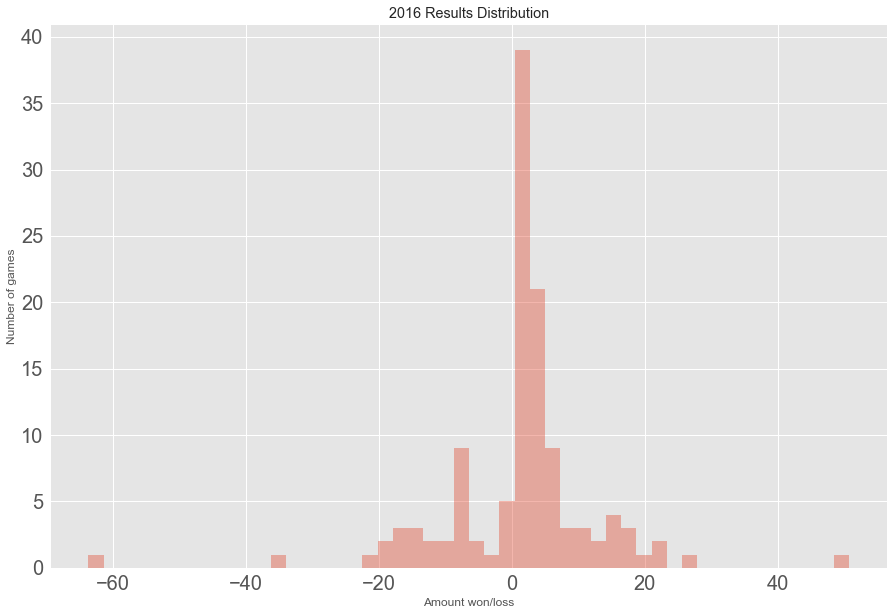

-------------------------------------------------------------------------------------
The final 10 bets for the year


,match_num,h_team,a_team,win_loc,bet_on,bank,new_bank,earn_loss
112,190,Adelaide,Port Adelaide,1,1,137.43,157.66,20.24
113,192,Geelong,Hawthorn,1,1,157.66,179.45,21.78
114,193,West Coast,Brisbane,1,1,179.45,180.99,1.54
115,194,Port Adelaide,St Kilda,1,1,180.99,185.97,4.98
116,195,Western Bulldogs,Fremantle,1,1,185.97,204.42,18.45
117,196,North Melbourne,Adelaide,1,1,204.42,225.81,21.39
118,197,Sydney,Collingwood,1,1,225.81,241.09,15.28
119,198,Gold Coast,Essendon,1,1,241.09,245.59,4.50
120,200,Richmond,Carlton,1,1,245.59,255.57,9.98
121,0,0,0,0,0,255.57,0.00,0.00


-------------------------------------------------------------------------------------
The largest 5 winning bets:


,match_num,h_team,a_team,win_loc,bet_on,bank,new_bank,earn_loss
99,171,Brisbane,Gold Coast,1,1,116.76,167.58,50.82
110,185,Hawthorn,West Coast,1,1,174.19,201.11,26.91
113,192,Geelong,Hawthorn,1,1,157.66,179.45,21.78
117,196,North Melbourne,Adelaide,1,1,204.42,225.81,21.39
112,190,Adelaide,Port Adelaide,1,1,137.43,157.66,20.24


The largest 5 losing bets:


,match_num,h_team,a_team,win_loc,bet_on,bank,new_bank,earn_loss
111,186,Fremantle,Gold Coast,0,1,201.11,137.43,-63.68
92,159,Fremantle,Carlton,0,1,121.91,85.74,-36.17
58,100,West Coast,Adelaide,0,1,88.34,68.02,-20.32
108,181,Richmond,Adelaide,0,1,188.67,169.17,-19.50
0,0,Sydney,Western Bulldogs,0,1,100.00,80.67,-19.33


-------------------------------------------------------------------------------------


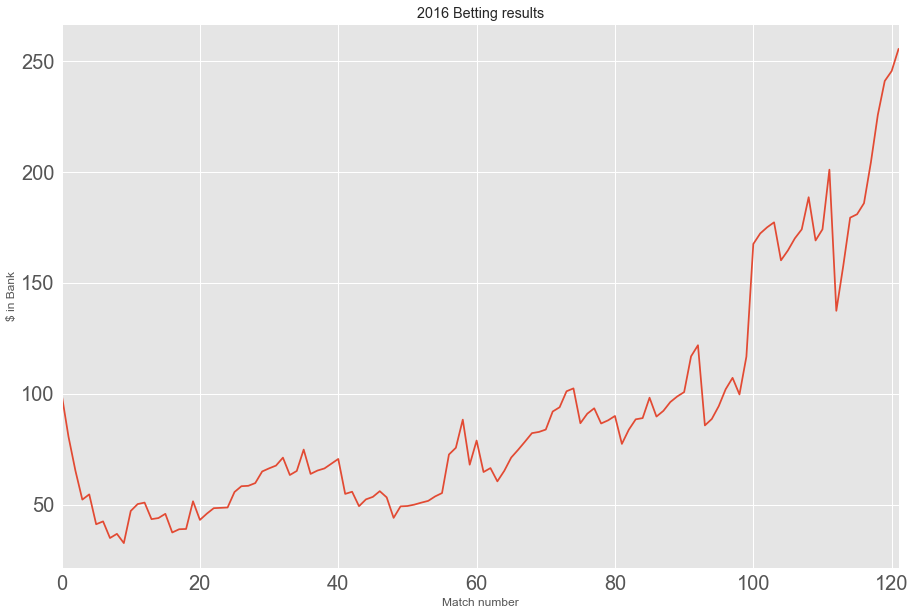

In [1234]:
year_analysis(year)

<a id='go_back'></a>

### Change year
<a href='#change_year'>Change year here</a>

<a href='#change_bettype'>Change bet type here</a>


In [1235]:
count = 0

for index, row in betting_outcomes_home.iterrows():
    num_games = len(betting_outcomes_home)

    if row["win_loc"] == row["bet_on"]:
        count += 1
    else:
        pass

print("I won {} bets out of {} games. That is {:.2f}% of games".format(count, num_games, count/num_games*100))

I won 95 bets out of 122 games. That is 77.87% of games
